In [44]:
from base import *
from utils import pauli_sum, entropy
from plot_tools import *
import qiskit as qk
from qiskit import QuantumCircuit, Aer, execute
from qiskit.primitives import Estimator
# from qiskit.utils import QuantumInstance
# from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, ADAM
from qiskit.opflow import X, Z, I, Y, AerPauliExpectation, PauliSumOp
from qiskit.circuit import Parameter
import numpy as np

### The Lipkin Model: $J=1$
$$
H_0 = \varepsilon J_z,
$$
$$
H_1 = \frac{1}{2} V \left( J_+^2 + J_-^2 \right).
$$
$$
H_2 = \frac{1}{2} W \left( -N + J_+ J_- + J_- J_+ \right).
$$
$$
\begin{equation}
H_{J = 1} =
\begin{pmatrix}-\epsilon & 0 & -V\\
 0&0&0\\
 -V&0&\epsilon
\end{pmatrix}
% \label{_auto6} \tag{6}
\end{equation}
$$

In [45]:
eps = 1
def H(v):    
    return np.array([[-eps, 0, -v], 
                     [0, 0, 0], 
                     [-v, 0, eps]])

H(0.5)

array([[-1. ,  0. , -0.5],
       [ 0. ,  0. ,  0. ],
       [-0.5,  0. ,  1. ]])

### Classical numerical solver for the eigenvalues and the Von Neumann entropy 

$$
S(A,B)=-\mathrm{Tr}\left(\rho_{A,B}\log_2 (\rho_{A,B})\right).
$$

In [46]:
vs = np.arange(0, 1, 0.01)
eigs = np.zeros((3, len(vs)))


for i, v in enumerate(vs):
    ham = H(v)
    eigvals, eigvecs = np.linalg.eig(H(v))
    eigs[:,i] = sorted(eigvals)




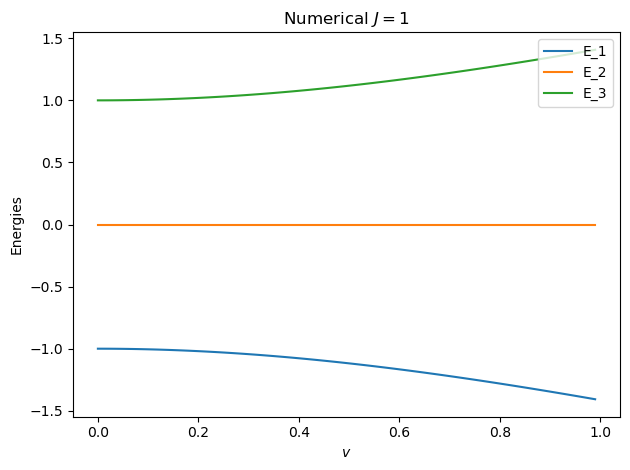

In [47]:
plot_2D(vs, eigs, plot_count=3, title=r"Numerical $J=1$", x_title=r'$v$', 
        label = [r'E_1', r'E_2', r'E_3'], y_title='Energies')

### VQE



In [48]:
def H(v): 
    return PauliSumOp.from_list([('ZI', (0.5 * eps)),
                                 ('IZ', (0.5 * eps)), 
                                 ('YY', (-0.5 * v)),
                                 ('XX', (0.5 * v))])

H(0)

PauliSumOp(SparsePauliOp(['ZI', 'IZ', 'YY', 'XX'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0. +0.j,  0. +0.j]), coeff=1.0)

Set up

In [49]:
def ansatz():
    '''creates an ansatz for vqe
    inputs:
        n: int, number of qubits
    return:
        qc: QuantumCircuit object, parametrized quantum circuit with given number of qubits, with parameters 
        thetas and phis
        '''
    n=2
    qc = QuantumCircuit(n)
    theta0 = Parameter('theta0')
    phi0 = Parameter('phi0')
    theta1 = Parameter('theta1')
    phi1 = Parameter('phi1')

    qc.rx(theta0,0)
    qc.ry(phi0,0)
    qc.rx(theta1,1)
    qc.ry(phi1,1)
    qc.cnot(0,1)
    
    return qc

def prep_vqe(n):
    '''input:
        n: int, number of qubits'''
    adam = ADAM(maxiter = 10000)
    slsqp = SLSQP(maxiter = 10000)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()

    vqe = VQE(ansatz=ansatz(), 
              optimizer=slsqp, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2*n), 
              estimator=estimator)

    return vqe
# vqe is sucessful becuase we enbed 2 qubit gates which, which creates highly entangled states. 
# Allowing us to explore multiple states at the same time. thetas needed for an n_qubit state doesn't have to scale exponentially with the number of qubits, but only linearly.


# def get_energy(angles, v, number_shots, target = None):
#     theta0, phi0, theta1, phi1 = angles
    
#     init_state = prepare_state(theta0, phi0, theta1, phi1, target)
#     qubit = Two_qubit()

#     ZI = np.kron(qubit.Z, qubit.I)

#     qubit.set_state(init_state)
#     qubit.apply_swap() # rotate measurement basis
#     measure_iz = qubit.measure(number_shots)

#     qubit.set_state(init_state)
#     measure_zi = qubit.measure(number_shots)
    
#     qubit.set_state(init_state)
#     qubit.apply_hadamard(0)
#     qubit.apply_hadamard(1)
#     qubit.apply_cnot10() # rotate measurement basis
#     measure_xx = qubit.measure(number_shots)
    
#     qubit.set_state(init_state)
#     qubit.apply_sdag(0)
#     qubit.apply_hadamard(0)
#     qubit.apply_sdag(1)
#     qubit.apply_hadamard(1)
#     qubit.apply_cnot10() # rotate measurement basis
#     measure_yy = qubit.measure(number_shots)
    

#     # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
#     exp_vals = np.zeros(4) # do not include the expectation value of II
#     measures = np.array([measure_iz, measure_zi, measure_xx, measure_yy])
#     constants = np.array([1/2, 1/2, -v/2, v/2])
#     for index in range(len(exp_vals)):
#         counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
#         exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

#     exp_val = np.sum(constants * exp_vals) / number_shots
#     return exp_val


In [50]:
n_points=100
n_qubits=2

vs = np.arange(n_points) # rmb to divide when used
vqe = prep_vqe(n_qubits)
energies = np.zeros(n_points) # containers for the energies

for i, v in enumerate(vs):
    v = v / n_points
    ham = H(v)
    print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    print(f'v = {v}, energy = {result.eigenvalue.real}')




0.5 * ZI
+ 0.5 * IZ
+ -0.0 * YY
+ 0.0 * XX
v = 0.0, energy = -0.9999999096174884
0.5 * ZI
+ 0.5 * IZ
- 0.005 * YY
+ 0.005 * XX
v = 0.01, energy = -1.0000496944008603
0.5 * ZI
+ 0.5 * IZ
- 0.01 * YY
+ 0.01 * XX
v = 0.02, energy = -1.000199903683052
0.5 * ZI
+ 0.5 * IZ
- 0.015 * YY
+ 0.015 * XX
v = 0.03, energy = -1.000449805796421
0.5 * ZI
+ 0.5 * IZ
- 0.02 * YY
+ 0.02 * XX
v = 0.04, energy = -1.000799580423328
0.5 * ZI
+ 0.5 * IZ
- 0.025 * YY
+ 0.025 * XX
v = 0.05, energy = -1.0012491194416087
0.5 * ZI
+ 0.5 * IZ
- 0.03 * YY
+ 0.03 * XX
v = 0.06, energy = -1.0017982856885614
0.5 * ZI
+ 0.5 * IZ
- 0.035 * YY
+ 0.035 * XX
v = 0.07, energy = -1.002446913578729
0.5 * ZI
+ 0.5 * IZ
- 0.04 * YY
+ 0.04 * XX
v = 0.08, energy = -1.0031948091398672
0.5 * ZI
+ 0.5 * IZ
- 0.045 * YY
+ 0.045 * XX
v = 0.09, energy = -1.0040417499861163
0.5 * ZI
+ 0.5 * IZ
- 0.05 * YY
+ 0.05 * XX
v = 0.1, energy = -1.0049874854775562
0.5 * ZI
+ 0.5 * IZ
- 0.055 * YY
+ 0.055 * XX
v = 0.11, energy = -1.0060317368951135

In [51]:
# plt.plot(vs/n_points, energies)
# plt.plot(vs/n_points, eigs[0])
plot_2D(vs/n_points, [energies, eigs[0]], plot_count=2, title="Ground state energies", x_title=r'$\lambda$', y_title='Energy', label=['vqe-qk', 'eigensolver'],
        filename='lipkin-2.pdf'), 
# save_fig('qk-1qb.pdf')
plt.show()

With **src.base**
$$
\begin{aligned}
H &= H_0 + H_1 \\
&= \frac{1}{2} (Z_1 + Z_2) + \frac{1}{2} V (X_1 \otimes X_1 + Y_2 \otimes Y_2)
\end{aligned}

In [58]:

def my_ansatz(params):
    '''params: list of parameters for the ansatz, [thetas, phis]'''
    qc = Qubits_2()
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rx(params[2], 1)
    qc.ry(params[3], 1)
    return qc

def my_H(v):
    return pauli_sum([('ZI', (0.5 * eps)),
                      ('IZ', (0.5 * eps)), 
                      ('YY', (-0.5 * v)),
                      ('XX', (0.5 * v))])


def expectation(qc, lmb, n_shots=100000):
    '''the expectation value of energy for the hamiltonian'''
    coeffs = {'IZ':0.5 * eps, 'ZI': 0.5 * eps, 'XX':0.5 * v, 'YY':-0.5 * v}

    # IZ
    qc_copy = qc.copy()
    qc_copy.swap() 
    count_iz = qc_copy.measure(n_shots=n_shots)[:,0] # only the couonts, don't keep the states

    # ZI
    qc_copy = qc.copy() # make a new copy everytime
    count_zi = qc_copy.measure(n_shots=n_shots)[:,0]

    # XX
    qc_copy = qc.copy()
    qc_copy.hadamard(0)
    qc_copy.hadamard(1)
    qc_copy.cnot(1,0)
    count_xx = qc_copy.measure(n_shots=n_shots)[:,0]

    # YY
    qc_copy = qc.copy()
    qc_copy.sdag(0)
    qc_copy.hadamard(0)
    qc_copy.sdag(1)
    qc_copy.hadamard(1)
    
    count_yy = qc_copy.measure(n_shots=n_shots)[:,0]

    expectaions = 0
    # ZI = (#00 + #01 - #10 - #11)/ number of shots
    # print(count_iz, count_zi, count_zz, count_xx)
    counts = [coeffs['IZ'] * count_iz, coeffs['ZI'] * count_zi, 
              coeffs['YY'] * count_yy, coeffs['XX'] * count_xx]
    
    # print(counts)
    for count in counts:
        # print(count)
        for i, state_count in enumerate(count):
            if i < 2:
                expectaions += state_count
            else:
                expectaions -= state_count
    return expectaions / n_shots


qc = Qubits_2()
expectation(qc, 1)


1.0014157000000001

In [59]:
a = my_ansatz(np.ones(4)* np.random.uniform(low=-np.pi/2, high=np.pi/2))
a

Qubit(s) in state: 
 0.81+0.18j|00⟩ + -0.30+0.24j|01⟩ + -0.30+0.24j|10⟩ + 0.00-0.18j|11⟩ 

In [60]:
from algorithms import Vqe 

In [61]:
n_points = 100

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=4)
my_vqe = Vqe(my_ansatz, init_points, expectation=expectation)

my_energies = np.zeros(n_points)
vs = np.arange(n_points)
for i, v in enumerate(vs):
    v = v / n_points
    my_ham = my_H(v)
    # print(my_ham)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham, v)
    print(f"v: {v}, energy: {min_energy}")
    my_energies[i] = min_energy



[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]
v: 0.0, energy: -1.0
[[ 1.  +0.j  0.  +0.j  0.  +0.j  0.01+0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.01+0.j  0.  +0.j  0.  +0.j -1.  +0.j]]
v: 0.01, energy: -1.0002441406249998
[[ 1.  +0.j  0.  +0.j  0.  +0.j  0.02+0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.02+0.j  0.  +0.j  0.  +0.j -1.  +0.j]]
v: 0.02, energy: -1.0006640625
[[ 1.  +0.j  0.  +0.j  0.  +0.j  0.03+0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.03+0.j  0.  +0.j  0.  +0.j -1.  +0.j]]
v: 0.03, energy: -1.0012890625
[[ 1.  +0.j  0.  +0.j  0.  +0.j  0.04+0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.04+0.j  0.  +0.j  0.  +0.j -1.  +0.j]]
v: 0.04, energy: -1.00203125
[[ 1.  +0.j  0.  +

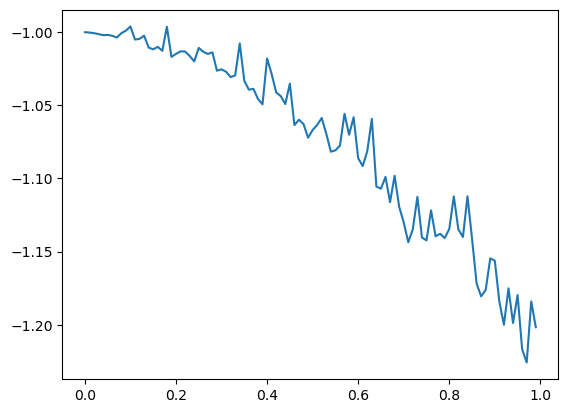

In [62]:
plt.plot(vs/n_points, my_energies)
plt.show()

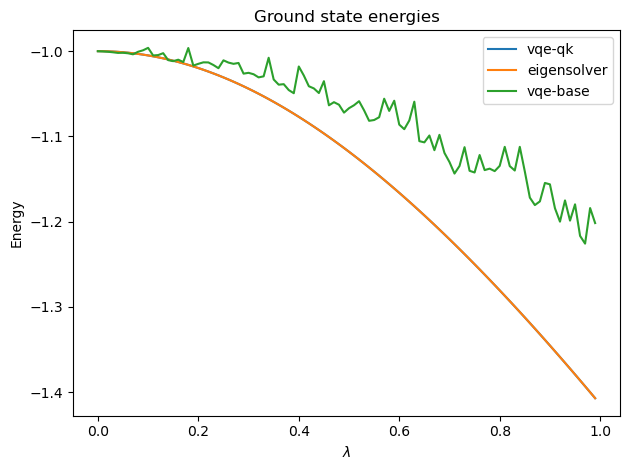

In [63]:
plot_2D(vs/n_points, [energies, eigs[0], my_energies], plot_count=3, title="Ground state energies", x_title=r'$\lambda$', y_title='Energy', label=['vqe-qk', 'eigensolver', 'vqe-base'],)
        # filename='lipkin-2.pdf'), 
